### Drag-Based Manipulation Demo

In [35]:
%load_ext autoreload
%autoreload 2

import gc
import json
import mediapy
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np
from omegaconf import OmegaConf
import os
from PIL import Image
import torch
from omegaconf import OmegaConf
from readout_guidance import rg_helpers
from script_drag import open_points, create_frames, viz_tracks, run_ddim_inversion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load the Stable Diffusion Pipeline and Readout Heads**

The demo is pre-loaded to operate on real images (`configs/drag_real.yaml`), which uses the SDv1-5 appearance and correspondence heads. To switch to generated images and the SDXL readout heads, simply switch the path to `configs/drag_generated.yaml`.

In [36]:
print(torch.cuda.is_available())

True


In [37]:
import yaml

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# config_path = "configs/drag_generated.yaml"
config_path = "configs/drag_real.yaml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
# Access values in the dictionary
if 'database' in config and 'host' in config['database']:
    print("Database Host:", config['database']['host'])
else:
    print("The specified path 'database.host' does not exist in the configuration.")


The specified path 'database.host' does not exist in the configuration.


In [39]:
# Load pipeline
pipeline, dtype = rg_helpers.load_pipeline(config, device)
batch_size = config["batch_size"]
latent_height = latent_width = pipeline.unet.config.sample_size
height = width = latent_height * pipeline.vae_scale_factor
image_dim = (width, height)
latent_dim = (latent_height, latent_width)

# Create edit config and load aggregation network
num_frames = config.get("num_frames", 2)
edits = rg_helpers.get_edits(config, device, dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Not using output head
Not using output head


**Load the Drag Input**

To try other drag inputs, change the `name` and `tracks_name` according to the image and tracks you want to use. If you are using `configs/drag_generated.yaml`, you can create new names for these fields, where you will generate the image according to `prompt` and annotate the tracks in later cells.

Other example drag inputs are located in `data/drag/real`, where they are organized as follows:
```
<name>
  |_ source.png
  |_ info.json
  |_ tracks_<tracks_name>.npy
```

In [40]:
name = "wolf-looking"
tracks_name = "multi-turn"
prompt = None

In [41]:
# Set prefix to [real, generated]
drag_prefix = os.path.basename(config_path).split("_")[1].split(".")[0]
save_folder = f"data/drag/{drag_prefix}/{name}"
first_frame_path = f"{save_folder}/source.png"
if not os.path.exists(save_folder):
    os.makedirs(save_folder, exist_ok=True)
meta_exists = os.path.exists(first_frame_path) and os.path.exists(f"{save_folder}/info.json")

if drag_prefix == "real":
    assert meta_exists, "For real images make sure the source.png and info.json exist"

if meta_exists:
    first_frame = Image.open(first_frame_path)
    ann = json.load(open(f"{save_folder}/info.json"))
    seed = ann["seed"]
    prompt = ann["prompt"]
else:
    # Run generation without readout guidance
    assert prompt is not None, "Must feed prompt if metadata does not exist"
    seed = config["seed"]
    prompts, latents = rg_helpers.get_prompts_latents(
        pipeline,
        prompt,
        1, 
        seed,
        latent_dim,
        device,
        dtype,
    )
    images, results = rg_helpers.run_preset_generation(
        pipeline,
        prompts, 
        latents,
        edits=[],
        latent_dim=latent_dim,
        **config["generation_kwargs"]
    )
    first_frame = Image.fromarray(images[0])
    # Create save_info and image
    ann = {
        "seed": seed,
        "video_name": name, 
        "image_dim": image_dim, 
        "prompt": prompt
    }
    json.dump(ann, open(f"{save_folder}/info.json", "w"))
    first_frame.save(f"{save_folder}/source.png")

**Annotate Drags**

If `tracks_name` does not refer to an existing set of drags, annotate in the interface.

In [24]:
tracks_file = f"{save_folder}/tracks_{tracks_name}.npy"
tracks_exist = os.path.exists(tracks_file)

In [25]:
if tracks_exist:
    tracks = np.load(tracks_file)
else:
  %matplotlib ipympl
  user_points = []

  fig, ax = plt.subplots(1, 1)
  ax.imshow(first_frame, alpha=0.3)
  ax.axis("off")
  plt.draw()

  def mouse_event(event):
    y, x = event.ydata, event.xdata
    radius = 10
    color = "gray"
    circ = plt.Circle((x, y), radius, facecolor=color, color=color)
    ax.add_patch(circ)
    if len(user_points) % 2 == 1:
      arrow = FancyArrowPatch(user_points[-1], (x, y),
                          arrowstyle='->', color='red', mutation_scale=20, linewidth=2)
      ax.add_patch(arrow)
    user_points.append((x, y))

  fig.canvas.mpl_connect('button_press_event', mouse_event)

In [26]:
# Save tracks
if not tracks_exist:
    assert user_points and len(user_points) % 2 == 0, "Every source point must have a target point"
    user_arr = np.array(user_points)
    source_arr, target_arr = user_arr[0::2, :], user_arr[1::2, :]
    tracks = np.stack([source_arr, target_arr])[None, ...]
    np.save(tracks_file, tracks)

**Run DDIM Inversion**

For real images, seed the generation process with the noise discovered by DDIM inversion. In this setting, you cannot use classifier-free guidance (`text_guidance`=1.0 which represents sampling only from the conditional branch).

Readout Guidance Loss N/A: : 90it [00:17,  5.55it/s]

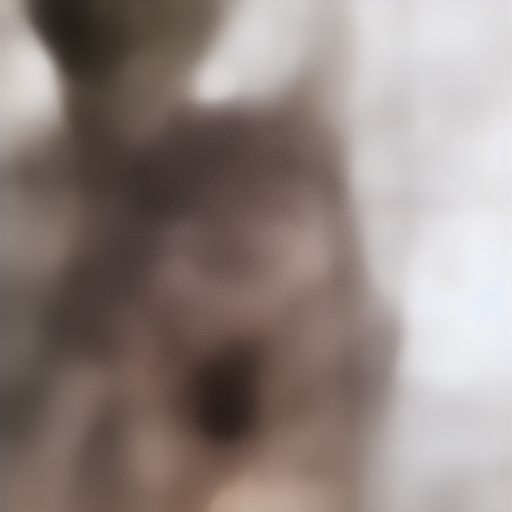

Readout Guidance Loss N/A: : 100it [00:19,  5.15it/s]


In [27]:
if "generated" in config_path:
    prompts, latents = rg_helpers.get_prompts_latents(
        pipeline,
        prompt,
        batch_size,
        seed,
        latent_dim,
        device,
        dtype,
    )
else:
    latents = run_ddim_inversion(
        config, 
        pipeline, 
        first_frame, 
        prompt,
        image_dim, 
        dtype,
        batch_size
    )
    prompts = [prompt] * batch_size

**Run Readout Guidance**

By default, the config `batch_size` is set to 2, where the left image is the result *without* readout guidance and the right image is the result *with* readout guidance. The cell will also log the readout guidance loss (if not applied, displayed as "N/A") and the predicted x0.

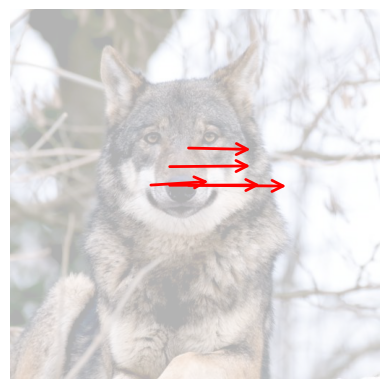

In [28]:
tracks_name, tracks, visibles, original_tracks, original_visibles = open_points(
    [tracks_file],
    ann,
    latent_dim,
    tracks_idx=0,
    interp_num=num_frames
)
tracks_frame = np.array(viz_tracks(first_frame, tracks, latent_dim).resize(image_dim))

script_drag.py

In [46]:
import glob
import json
from io import BytesIO
import os
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import mediapy
import numpy as np
from PIL import Image
import sys
import torch
from tqdm import tqdm
import yaml

from readout_guidance import rg_helpers, rg_operators

Edit helpers

In [47]:
def set_edits_points(edits, points):
    for edit in edits:
       if edit["head_type"] == "correspondence":
            edit["points"] = points
    return edits

def set_edits_image(edits, image):
    for edit in edits:
        if edit["head_type"] == "appearance":
            edit["control_image"] = image
    return edits

Point Helpers

In [48]:
def interpolate_points(points, alpha):
    points1, points2 = points[0].copy(), points[1].copy()
    dx = points2[:, 0] - points1[:, 0]
    dy = points2[:, 1] - points1[:, 1]
    points2 = points1.copy()
    points2[:, 0] = points2[:, 0] + alpha * dx
    points2[:, 1] = points2[:, 1] + alpha * dy
    points = np.stack([points1, points2])
    return points

def latent_points(tracks, visibles, image_dim, latent_dim):
    tracks, visibles = tracks[0], visibles[0]
    f, n, c = tracks.shape
    tracks = tracks[..., (1, 0)]
    tracks = rg_operators.rescale_points(tracks, image_dim, latent_dim)
    tracks = torch.from_numpy(tracks)
    return tracks, visibles

def open_points(tracks_file, ann, latent_dim, tracks_idx=0, interp_num=None):
    tracks_name = tracks_file[tracks_idx]
    visibles_file = tracks_name.replace("tracks", "visibles")
    tracks = np.load(tracks_name)
    if os.path.exists(visibles_file):
        visibles = np.load(visibles_file)
    else:
        visibles = np.ones((1, 2, tracks.shape[-2]))
    # Interpolate for image animation
    if tracks.shape[1] == 2 and interp_num:
        interp_tracks = []
        interp_visibles = []
        for alpha in np.linspace(0, 1, interp_num):
            interp_tracks.append(interpolate_points(tracks[0], alpha)[1][None, None, ...])
            interp_visibles.append(visibles[:, 0, :][:, None, :])
        tracks = np.concatenate(interp_tracks, axis=1)
        visibles = np.concatenate(interp_visibles, axis=1)
    # Convert points from (x, y) to (y, x)
    image_dim = ann["image_dim"][::-1]
    original_tracks, original_visibles = tracks, visibles
    tracks, visibles = latent_points(tracks, visibles, image_dim, latent_dim)
    return tracks_name, tracks, visibles, original_tracks, original_visibles

def subselect_points(points, n):
    points_idxs = np.random.permutation(range(points.shape[1]))
    points_idxs = points_idxs[:min(n, len(points_idxs))]
    points = points[:, points_idxs, :]
    return points

def viz_tracks(first_frame, tracks, latent_dim, save_file=None):
    tracks = tracks.detach().clone()
    tracks = rg_operators.rescale_points(tracks, latent_dim, first_frame.size[::-1])
    tracks = tracks[..., (1, 0)] # (y, x) -> (x, y)
    tracks = tracks[(0, -1), :, :] # select first and last frame
    fig, ax = plt.subplots()
    # Fade the image
    ax.imshow(first_frame, alpha=0.3)
    for i in range(tracks.shape[1]):
        arrow = FancyArrowPatch((tracks[0, i, 0], tracks[0, i, 1]), (tracks[1, i, 0], tracks[1, i, 1]),
                            arrowstyle='->', color='red', mutation_scale=20, linewidth=2)
        ax.add_patch(arrow)
    ax.axis("off")
    if save_file is None:
        buffer = BytesIO()
        save_file = buffer
    plt.savefig(save_file, bbox_inches='tight', pad_inches=0)
    img = Image.open(save_file).convert("RGB")
    return img

Generation helpers

In [49]:
def open_first_frame(tracks_file):
    first_frame_file = f"{os.path.dirname(tracks_file[0])}/source.png"
    if os.path.exists(first_frame_file):
        first_frame = Image.open(first_frame_file)
    else:
        first_frame = None
    return first_frame

In [92]:
def create_frames(pipeline, prompts,latents,edits, latent_dim, config, tracks, visibles,num_frames,first_frame):
    num_frames = min(num_frames, tracks.shape[0])
    print("num_frames:", num_frames)
    predicted_frames = []
    for i in range(1, num_frames):
        frame_latents = latents.detach().clone()
        print("frame_latents:", frame_latents)
        # Select points covisible pairs of frames
        points = tracks[(0, i), :, :]
        visible_points = visibles[(0, i), :].all(axis=0)
        points = points[:, visible_points, :]
        edits = set_edits_points(edits, points)
        edits = set_edits_image(edits, first_frame)
        images, _ = rg_helpers.run_preset_generation(
            pipeline, 
            prompts, 
            frame_latents, 
            edits, 
            latent_dim=latent_dim,
            **config["generation_kwargs"]
        )
        if len(predicted_frames) == 0:
            predicted_frames.append(images[0])
        predicted_frames.append(images[1])
    return predicted_frames

In [93]:
def run_ddim_inversion(config, pipeline, first_frame, prompt, image_dim, dtype, batch_size):
    with torch.no_grad():
        generation_kwargs = {k: v for k, v in config["generation_kwargs"].items() if k != "text_weight"}
        guidance_scale = config["generation_kwargs"]["text_weight"]
        if type(guidance_scale) is not float:
            guidance_scale = guidance_scale[0]
        _, inverted_latents = rg_helpers.run_preset_inversion(
            pipeline, 
            first_frame, 
            prompt, 
            image_dim=image_dim,
            dtype=dtype,
            text_weight=guidance_scale,
            **generation_kwargs
        )
        latents = torch.cat([inverted_latents[0].detach().clone() for _ in range(batch_size)], dim=0)
        latents = latents.to(dtype)
    return latents

In [94]:
config = OmegaConf.load(config_path)
assert config.get("same_seed", True) is True, "Only same_seed currently supported"
print(config)


{'model_path': 'runwayml/stable-diffusion-v1-5', 'batch_size': 2, 'seed': 100, 'num_frames': 2, 'fps': 1, 'rg_kwargs': [{'head_type': 'appearance', 'loss_rescale': 1.0, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdv15_drag_appearance.pt'}}, {'head_type': 'correspondence', 'loss_rescale': 1.0, 'use_emb': False, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdv15_drag_correspondence.pt'}}], 'generation_kwargs': {'text_weight': [1.0, 3.5], 'rg_weight': 0.02, 'rg_ratio': [0.0, 0.5], 'eta': 0.0, 'num_timesteps': 100, 'negative_prompt': 'poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off'}, 'run_ddim_inversion': True, 'output_dir': 'results/drag/real', 'points_root': 'data/drag/real'}


In [95]:
pipeline, dtype = rg_helpers.load_pipeline(config, device)
print(pipeline)
print(dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.11.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

torch.float32


In [96]:
batch_size = config["batch_size"]
print(batch_size)

2


In [97]:
latent_height = latent_width = pipeline.unet.config.sample_size
height = width = latent_height * pipeline.vae_scale_factor
image_dim = (width, height)
latent_dim = (latent_height, latent_width)
print("image_dim:", image_dim)
print("latent_dim:", latent_dim)



image_dim: (512, 512)
latent_dim: (64, 64)


Creating root save folder

In [98]:
save_folder = config["output_dir"]
print(save_folder)
if not os.path.exists(save_folder):
        os.makedirs(save_folder, exist_ok=True)
OmegaConf.save(config, f"{save_folder}/config.yaml")

results/drag/real


creating edit config and load aggregation network

In [66]:
num_frames = config.get("num_frames", 2)
print("number of frames:", num_frames)
edits = rg_helpers.get_edits(config, device, dtype)
print("edits:",edits)
#ann_paths = glob.glob(f"{config['points_root']}/*/info.json")

number of frames: 2
Not using output head
Not using output head
edits: [{'head_type': 'appearance', 'loss_rescale': 1.0, 'aggregation_kwargs': {'aggregation_ckpt': 'weights/readout_sdv15_drag_appearance.pt', 'projection_dim': 384, 'model_id': 'runwayml/stable-diffusion-v1-5', 'output_resolution': 64, 'load_resolution': 512, 'diffusion_mode': 'generation', 'num_timesteps': 1000, 'save_timestep': [0], 'prompt': '', 'negative_prompt': '', 'guidance_scale': -1, 'weight_decay': 0, 'max_steps': 1000, 'val_every_n_steps': 100, 'log_max': 10, 'lr': 0.0001, 'dataset_args': {'size': 512, 'target_select': 'max_aligned', 'sdedit_root': 'sdedit/DAVIS', 'sdedit_select': 'strength-0.5_gs-3.5_v1', 'objectives': ['rs'], 'min_dist': 1, 'max_dist': 24}, 'batch_size': 1, 'pck_threshold': 0.1, 'use_dataloader': True, 'train_file': ['DAVIS_train.json'], 'val_file': ['DAVIS_val_subset.json'], 'triplet_kwargs': {'train_samples': 2, 'val_samples': 2, 'cosine_loss': True, 'margin': 0.5}, 'plot_every_n_steps': 1

noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


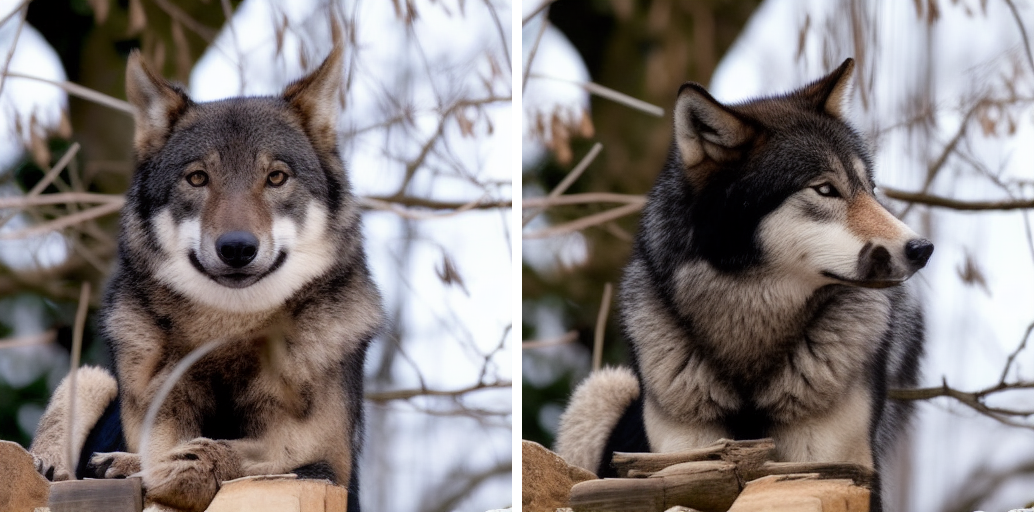

noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


noise pred uncond: torch.Size([2, 4, 64, 64])
noise pred cond: torch.Size([2, 4, 64, 64])
noise pred chunk: torch.Size([4, 4, 64, 64])
guidance_scale after processing: torch.Size([2, 1, 1, 1]) tensor([[[[1.0000]]],


        [[[3.5000]]]])


Readout Guidance Loss N/A: : 100it [01:07,  1.48it/s]


predicted frames: [array([[[250, 248, 251],
        [248, 250, 253],
        [248, 248, 254],
        ...,
        [241, 245, 251],
        [241, 247, 255],
        [240, 246, 248]],

       [[248, 252, 255],
        [246, 251, 255],
        [246, 250, 255],
        ...,
        [240, 245, 252],
        [243, 245, 253],
        [243, 248, 255]],

       [[249, 247, 255],
        [247, 251, 255],
        [248, 249, 253],
        ...,
        [236, 244, 249],
        [241, 246, 251],
        [241, 247, 254]],

       ...,

       [[128,  90,  62],
        [141, 103,  78],
        [142, 104,  80],
        ...,
        [226, 228, 236],
        [235, 235, 241],
        [236, 239, 244]],

       [[135,  97,  71],
        [144, 104,  81],
        [146, 108,  82],
        ...,
        [235, 241, 244],
        [235, 238, 240],
        [230, 237, 237]],

       [[138, 105,  83],
        [143, 105,  79],
        [147, 107,  77],
        ...,
        [228, 239, 245],
        [225, 234, 236],
     

100%|██████████| 3/3 [04:34<00:00, 91.66s/it]


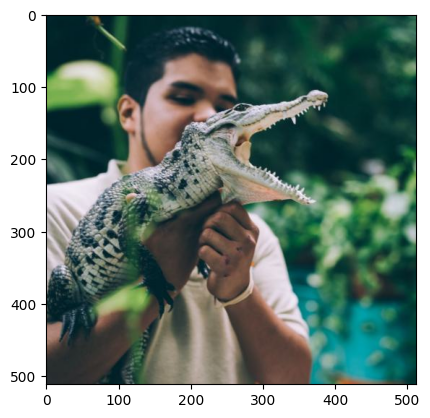

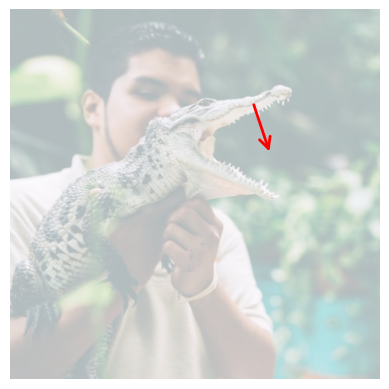

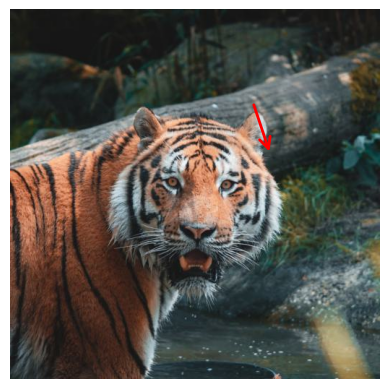

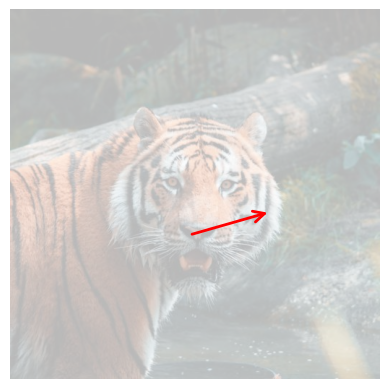

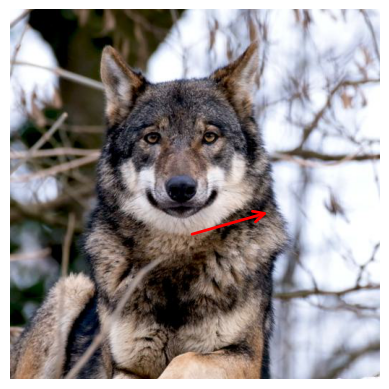

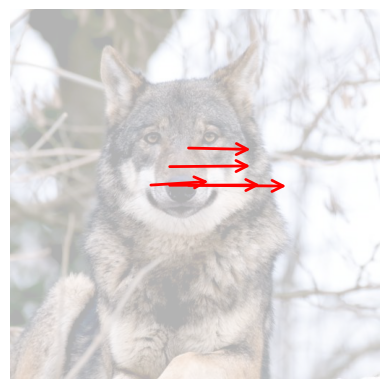

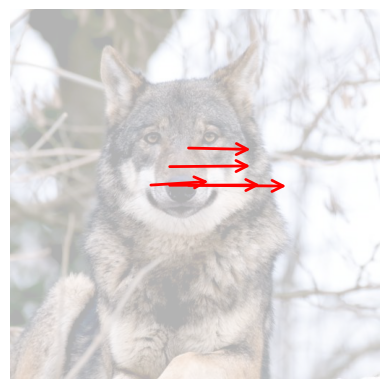

In [125]:
ann_paths = glob.glob(f"{config['points_root']}/*/info.json")
print("annotation paths:", ann_paths)
for ann_path in tqdm(ann_paths):
    ann = json.load(open(ann_path))
    print(ann)
    name, prompt = ann["video_name"], ann["prompt"]
    print(name)
    print(prompt)
    tracks_file = list(sorted(glob.glob(f"{config['points_root']}/{ann['video_name']}/tracks*")))
    print("tracks_file:", tracks_file)
    first_frame = open_first_frame(tracks_file)
    first_frame = first_frame.resize(image_dim)
    plt.imshow(first_frame)
    seed = ann["seed"]
    prompts, latents = rg_helpers.get_prompts_latents(pipeline,prompt,batch_size, seed,latent_dim,device,dtype)
    print(prompts, latents.shape)
    if config.get("run_ddim_inversion", False):
        latents = run_ddim_inversion(config, pipeline, first_frame, prompt, image_dim, dtype, batch_size)
        print("ddim latent:", latents)
    for tracks_idx in range(len(tracks_file)):
        tracks_name, tracks, visibles, original_tracks, original_visibles = open_points(tracks_file, ann, latent_dim, tracks_idx=tracks_idx, interp_num=num_frames)
        print("track_name:", tracks_name)
        print("tracks:", tracks)
        print("visibles:", visibles)
        print("original_tracks:", original_tracks)
        print("original_visibles:", original_visibles)
        predicted_frames = create_frames(pipeline, prompts, latents, edits,latent_dim, config, tracks, visibles,num_frames,first_frame)
        print("predicted frames:", predicted_frames)

        ## create tracks folder 
        save_name = os.path.basename(tracks_name).split("_")[1].split(".")[0]
        ann_name = ann['video_name'].split('.')[0]
        if name != ann_name:
            save_name = name + "_" + save_name 
        drag_folder = f"{save_folder}/{ann_name}/{save_name}"
        if not os.path.exists(drag_folder):
            os.makedirs(drag_folder, exist_ok=True) 
         # Save tracks info
        viz_tracks(first_frame, tracks, latent_dim, f"{drag_folder}/tracks.png")
        np.save(f"{drag_folder}/tracks.npy", original_tracks)
        np.save(f"{drag_folder}/visibles.npy", original_visibles)
        # Save frames
        for i, frame in enumerate(predicted_frames):
            Image.fromarray(frame).save(f"{drag_folder}/rg_{str(i).zfill(5)}.png")
        # Prepend the first frame and tracks
        tracks_frame = np.array(viz_tracks(first_frame, tracks, latent_dim).resize(image_dim))
        predicted_frames = [predicted_frames[0], tracks_frame] + predicted_frames
        mediapy.write_video(f"{drag_folder}/rg.gif", np.stack(predicted_frames), fps=config["fps"], codec="gif")


wolf looking around




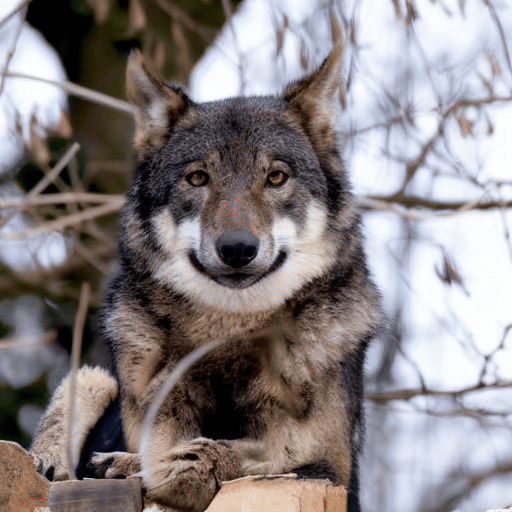

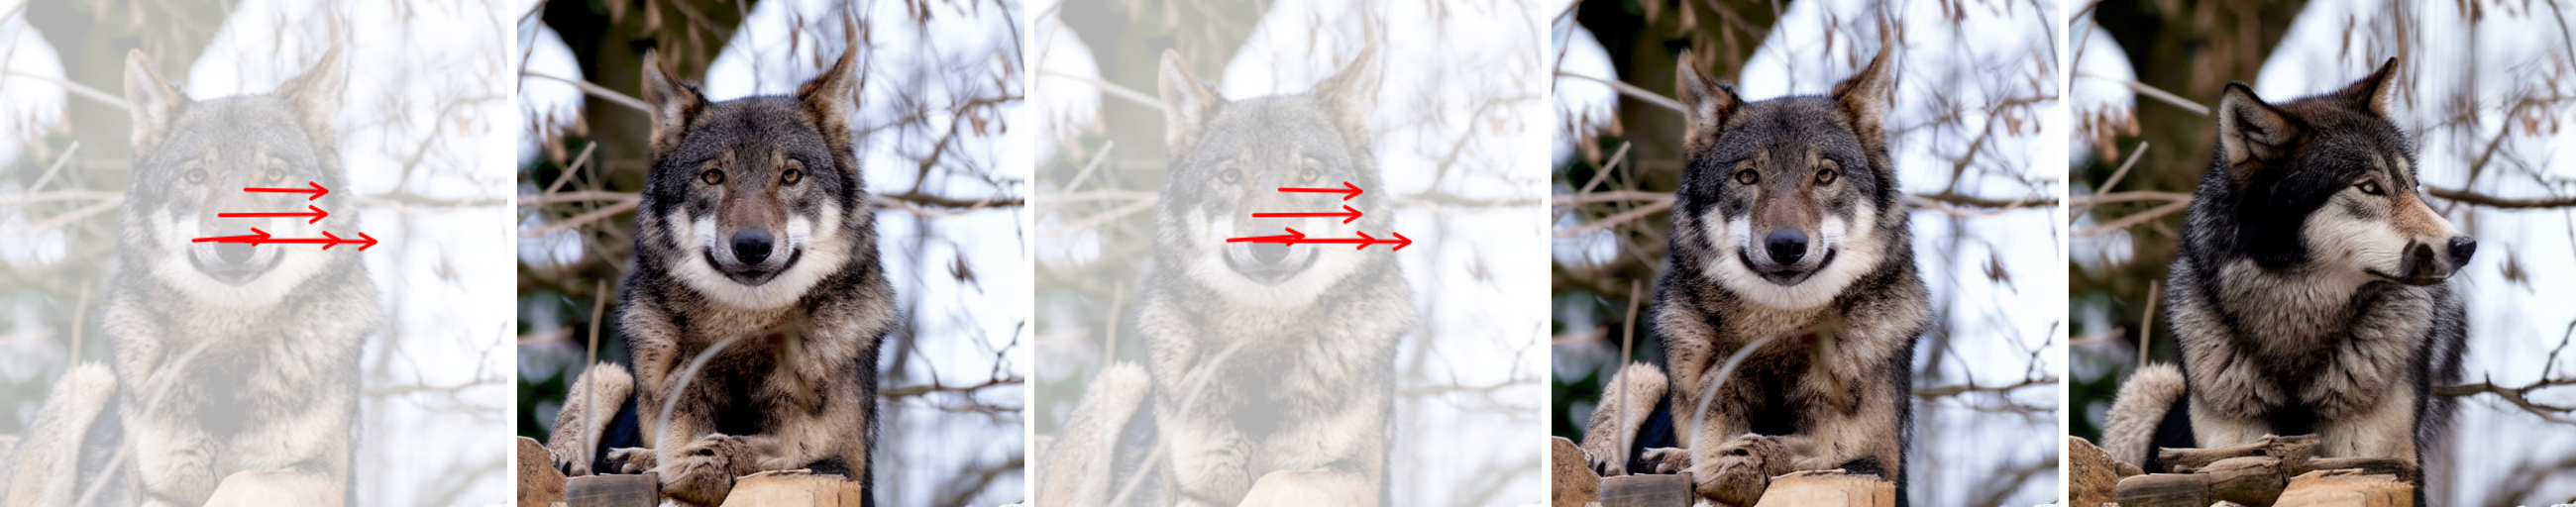

In [ ]:
viz_dim = (512, 512)
prompt_sep = "=" * 60
print(prompt_sep)
print(prompt)
print(prompt_sep)
print()
%matplotlib inline
plt.clf()
frames = np.stack([predicted_frames[0], tracks_frame] + predicted_frames)
video = mediapy.resize_video(frames, viz_dim)
mediapy.show_video(video, fps=config["fps"], codec="gif")
plt.clf() 
display(rg_helpers.view_images(frames[1:]))